In [ ]:
# This is a series of examples using the icanswim/qchem quantum mechanic machine learning repo
# icanswim/qchem utilizes the icanswim/cosmosis data science machine learning repo

In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../')

import warnings
warnings.filterwarnings('ignore', category=UserWarning,
                            message='TypedStorage is deprecated')

from cosmosis.model import FFNet
from cosmosis.dataset import SKDS, Pad, Flatten, Reshape, SqueezeN
from cosmosis.learning import Learn, Selector

from dataset import QM7, QM7b, QM7X, ANI1x, QM9, PGDS
from model import pyg_model, GraphNet, GlobalAttentionNet

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss, NLLLoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch_geometric.loader import DataLoader



In [2]:
#example exploring cosmosis/qchem QM9 dataset 
#use the qchem rdkit branch for rdkit data augmentation

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['atomic_number','mulliken'],
                                                             'coulomb': ['coulomb'],
                                                            },
                                             'criterion_input': {'target': ['U0']}},
                              'n': 1000, #non-random subset for testing,
                              'use_pickle': False}}

qm9 = QM9(**ds_params['train_params'])
qm9[1]

creating QM9 dataset...
molecules scanned:  1
molecules created:  1
total molecules scanned:  1000
total uncharacterized molecules removed:  25
total molecules created:  975
CDataset created...


{'model_input': {'X': array([ 6.      ,  1.      ,  1.      ,  1.      ,  1.      , -0.535689,
          0.133921,  0.133922,  0.133923,  0.133923], dtype=float32),
  'coulomb': array([[36.858112 , 10.765888 , 10.765641 , 10.765677 , 10.765863 ],
         [ 0.9157932,  0.5      ,  1.7942736,  1.7942796,  1.7943105],
         [ 0.9157932,  1.7943147,  0.5      ,  1.7942796,  1.7943105],
         [ 0.9157932,  1.7943147,  1.7942736,  0.5      ,  1.7943105],
         [ 0.9157932,  1.7943147,  1.7942736,  1.7942796,  0.5      ]],
        dtype=float32)},
 'criterion_input': {'target': array([-40.47893], dtype=float32)}}

In [3]:
#example exploring cosmosis/qchem QM9 dataset
l, s, li, si = 0, 9999, 0, 0
for i in qm9.ds_idx:
    d = qm9[i]['model_input']['X'].shape[0]
    if d > l:
        l = d
        li = i
    if d < s:
        s = d
        si = i
print('longest molecule index: ', li, ' length: ', l)
print('shortest molecule index: ', si, ' length: ', s)
qm9[si]

longest molecule index:  228  length:  40
shortest molecule index:  3  length:  6


{'model_input': {'X': array([ 8.      ,  1.      ,  1.      , -0.589706,  0.294853,  0.294853],
        dtype=float32),
  'coulomb': array([[73.51671  , 35.90347  , 35.90347  ],
         [ 1.0393857,  0.5      ,  4.4879336],
         [ 1.0393857,  4.4879336,  0.5      ]], dtype=float32)},
 'criterion_input': {'target': array([-76.4047], dtype=float32)}}

In [4]:
#example exploring cosmosis/qchem PyG dataset wrapper with Data object output
import numpy as np
import torch_geometric.transforms as T

ds_params = {'train_params': {'dataset': 'QM9',
                              'pg_params': {'root': './data/',
                                            'transform': T.AddSelfLoops()}}}

pgds = PGDS(**ds_params['train_params'])
ds_idx = np.arange(1000)
selector = Selector(train_idx=ds_idx)
selector('train')
loader = DataLoader(pgds, batch_size=2, sampler=selector)
batch = next(iter(loader))
print('batch: ', batch)
print('batch.ptr: ', batch.ptr)
print('batch.idx: ', batch.idx)
print('batch.x: ', batch.x)
print('pgds[1]: ', pgds[1])
print('pgds[1].x: ', pgds[1].x)
print('pgds[1].y: ', pgds[1].y)
print('pgds[1].idx: ', pgds[1].idx)

creating pytorch geometric QM9 dataset...
CDataset created...
batch:  DataBatch(x=[21, 11], edge_index=[2, 61], edge_attr=[40, 4], y=[2, 19], pos=[21, 3], z=[21], name=[2], idx=[2], batch=[21], ptr=[3])
batch.ptr:  tensor([ 0, 12, 21])
batch.idx:  tensor([505, 912])
batch.x:  tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 3.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 8., 0., 0., 0., 0., 0.],
        [0., 1., 0., 

In [5]:
#example exploring cosmosis/qchem PyG dataset wrapper, padded with dictionary output

ds_params = {'train_params': {'dataset': 'QM9',
                              'input_dict': {'model_input': {'X': ['x'],
                                                             'edge_index': ['edge_index']},
                                             'criterion_input': {'target': ['y']}},
                              'transforms': {'edge_index': [Reshape((-1,1))]},
                              'pg_params': {'root': './data/'}}}

pgds = PGDS(**ds_params['train_params'])
print(pgds[1]['model_input']['edge_index'].shape)
print(pgds[1])

creating pytorch geometric QM9 dataset...
CDataset created...
torch.Size([12, 1])
{'model_input': {'X': tensor([[0., 0., 1., 0., 0., 7., 0., 0., 0., 0., 3.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]), 'edge_index': tensor([[0],
        [0],
        [0],
        [1],
        [2],
        [3],
        [1],
        [2],
        [3],
        [0],
        [0],
        [0]])}, 'criterion_input': {'target': tensor([[ 1.6256e+00,  9.4600e+00, -6.9933e+00,  2.2558e+00,  9.2491e+00,
          2.6156e+01,  9.3493e-01, -1.5381e+03, -1.5381e+03, -1.5380e+03,
         -1.5387e+03,  6.3160e+00, -1.2006e+01, -1.2082e+01, -1.2159e+01,
         -1.1246e+01,  2.9361e+02,  2.9354e+02,  1.9139e+02]])}}


In [11]:
ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['U0']}},
                              'n': 10, #non-random subset for testing
                              'transforms': {'coulomb': [Pad((6,6))]},
                              'filter_on': ('n_atoms','<','7'), #filter out molecules with more than 7 atoms
                              'use_pickle': False}}

qm9 = QM9(**ds_params['train_params'])
print('dataset index: ', qm9.ds_idx)
qm9[1]

creating QM9 dataset...
molecules scanned:  1
molecules created:  1
total molecules scanned:  23
total uncharacterized molecules removed:  0
total molecules created:  10
CDataset created...
dataset index:  [1, 2, 3, 4, 5, 6, 8, 10, 12, 23]


{'model_input': {'X': array([[36.858112 , 10.765641 , 10.765863 , 10.765677 , 10.765888 ,
           0.       ],
         [ 0.9157932,  0.5      ,  1.7943105,  1.7942796,  1.7943147,
           0.       ],
         [ 0.9157932,  1.7942736,  0.5      ,  1.7942796,  1.7943147,
           0.       ],
         [ 0.9157932,  1.7942736,  1.7943105,  0.5      ,  1.7943147,
           0.       ],
         [ 0.9157932,  1.7942736,  1.7943105,  1.7942796,  0.5      ,
           0.       ],
         [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
           0.       ]], dtype=float32)},
 'criterion_input': {'target': array([-40.47893], dtype=float32)}}

creating QM9 dataset...
molecules scanned:  1
molecules created:  0
molecules scanned:  10001
molecules created:  9551
total molecules scanned:  10450
total uncharacterized molecules removed:  265
total molecules created:  9735
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:03.067366
epoch: 0, lr: 0.01
train loss: 200079.61506035214, val loss: 79.82431666056316
learning time: 0:00:13.999316
epoch: 8, lr: 0.01
train loss: 62.91560363769531, val loss: 59.31134329901801
test loss: 55.5278197394477
learning time: 0:00:15.685819


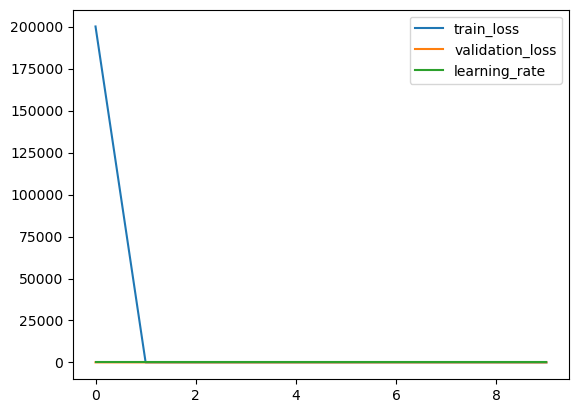

In [7]:
#example cosmosis/qchem QM9 dataset with filter
#use the qchem rdkit branch for rdkit data augmentation

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['U0']}},
                              'n': 10000, #non-random subset for testing
                              'transforms': {'coulomb': [Pad((29,29)),Reshape((1,-1))],
                                             'U0': [SqueezeN()]},
                              'filter_on': ('n_atoms','>','10'), #filter out molecules with less than 10 atoms
                              'use_pickle': False}}

model_params = {'in_channels': 29*29, 
                'hidden': 4096, 
                'out_channels': 1, 
                'model_name': 'funnel'
               }
                
metrics_params = {'report_interval': 1,
                  'log_plot': False}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 'subset': .2 #create random subset
                }

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          squeeze_y_pred=True, batch_size=32, epochs=10)

creating pytorch geometric TUDataset dataset...
CDataset created...
CModel loaded...
running model on gpu...
learning time: 0:00:00.798475
epoch: 0, lr: 0.01
train loss: 0.08223593863658607, val loss: 0.07467229912678401
sklearn train metric: 0.609375, sklearn validation metric: 0.75
learning time: 0:00:03.190828
epoch: 3, lr: 0.01
train loss: 0.0641903521027416, val loss: 0.08519492298364639
sklearn train metric: 0.7265625, sklearn validation metric: 0.5
learning time: 0:00:05.575158
epoch: 6, lr: 0.005
train loss: 0.06748405960388482, val loss: 0.08542569354176521
sklearn train metric: 0.7265625, sklearn validation metric: 0.625
learning time: 0:00:07.954534
epoch: 9, lr: 0.0025
train loss: 0.06432409677654505, val loss: 0.0728482852379481
sklearn train metric: 0.71875, sklearn validation metric: 0.5833333333333334
test loss: 0.07438354318340619
learning time: 0:00:08.298253
sklearn test metric: 
0.6666666666666666 



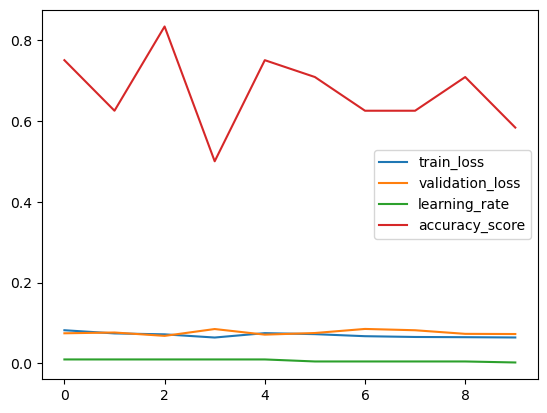

In [12]:
#example cosmosis/qchem PyG dataset wrapper with Data object output and
#sklearn metrics and custom PyG model

model_params = {'in_channels': 7,
                'hidden': 64,
                'out_channels': 2,
                'depth': 2}

ds_params = {'train_params': {'dataset': 'TUDataset',
                              'pg_params': {'root': './data/',
                                            'name': 'MUTAG'}}}

metrics_params = {'report_interval': 2,
                  'log_plot': False,
                  'sk_metric_name': 'accuracy_score',
                  'sk_params': {}}

opt_params = {'lr': 0.01}

crit_params = {}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

l = Learn([PGDS], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=CrossEntropyLoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=8, epochs=10)

In [ ]:
import numpy as np

class IndexTransform():
    #select index i from dataset with multiple target outputs
    def __init__(self, i):
        self.i = i
    def __call__(self, arr):
        return np.reshape(arr[self.i], (1,))


model_params = {'in_channels': 11, 
                'hidden': 512, 
                'out_channels': 1,
                'depth': 2}

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': IndexTransform(1)}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

l = Learn([PGDS], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=10)

In [ ]:
import numpy as np

class IndexTransform():
    #select index i from dataset with multiple target outputs
    def __init__(self, i):
        self.i = i
    def __call__(self, arr):
        return np.reshape(arr[self.i], (1,))
    
ds_params = {'train_params': {'dataset': 'QM9',
                              'use_pyg': False,
                              'transform': [IndexTransform(1)],
                              'pg_params': {'root': './data/'}}}

pgds = PGDS(**ds_params['train_params'])
print(pgds[1])


In [ ]:
model_params = {'in_channels': 7,
                'hidden': 64,
                'out_channels': 2,
                'depth': 2}

ds_params = {'train_params': {'dataset': 'TUDataset',
                              'pg_params': {'root': './data/',
                                            'name': 'MUTAG'}}}

metrics_params = {'report_interval': 2,
                  'log_plot': False,
                  'sk_metric_name': 'accuracy_score',
                  'sk_params': {}}

opt_params = {'lr': 0.01}

crit_params = {}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

l = Learn([PGDS], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=CrossEntropyLoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=8, epochs=10)

In [ ]:
model_params = {'in_channels': 7,
                'hidden': 64,
                'out_channels': 2,
                'depth': 2}

ds_params = {'train_params': {'dataset': 'TUDataset',
                              'pg_params': {'root': './data/',
                                            'name': 'MUTAG'}}}

metrics_params = {'report_interval': 2,
                  'log_plot': False,
                  'sk_metric_name': 'accuracy_score',
                  'sk_params': {}}

opt_params = {'lr': 0.01}

crit_params = {}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

l = Learn([PGDS], GlobalAttentionNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=CrossEntropyLoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=8, epochs=10)

In [ ]:
#example cosmosis/qchem PyG dataset wrapper with custum transform with
#dictionary output and custom model
import numpy as np

class IndexTransform():
    #select index i from dataset with multiple target outputs
    def __init__(self, i):
        self.i = i
    def __call__(self, arr):
        return np.reshape(arr[self.i], (1,))

model_params = {'in_channels': 319, 
                'hidden': 512, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'dataset': 'QM9',
                              'use_pyg': False,
                              'pad': (29,11),
                              'pad_feats': ['x'],
                              'flatten': True,
                              'target_transform': [IndexTransform(1)],
                              'input_dict': {'model_input': {'X': ['x']},
                                             'criterion_input': {'target': ['y']}},
                              'pg_params': {'root': './data/'}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

l = Learn([PGDS], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=10)

In [ ]:
#test
import numpy as np

class IndexTransform():
    #select index i from dataset with multiple target outputs
    def __init__(self, i):
        self.i = i
    def __call__(self, arr):
        return np.reshape(arr[self.i], (1,))

model_params = {'in_channels': 11, 
                'hidden': 512, 
                'out_channels': 1,
                'depth': 2}

ds_params = {'train_params': {'dataset': 'QM9',
                              'target_transform': [IndexTransform(1)],
                              'pg_params': {'root': './data/'}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

l = Learn([PGDS], GlobalAttentionNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=10)

In [ ]:
#example using cosmosis/qchem QM7 dataset and custom model
model_params = {'in_channels': 23*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['ae']}},
                              'in_file': './data/qm7/qm7.mat',
                              'flatten': True}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 3,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=20)

In [ ]:
#example using the cosmosis/qchem QM7b dataset and custom model
model_params = {'in_channels': 23*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['E']}},
                              'in_file': './data/qm7b/qm7b.mat',
                              'flatten': True}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 3,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7b], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=256, epochs=20)

In [ ]:
#example exploring cosmosis/qchem QM7X dataset

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','eAT','hDIP',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb'] #(1110,) with pad=23

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['atNUM']},
                                             'criterion_input': {'target': ['eAT']}},
                              'pad': None, #longest molecule = 23
                              'as_tensor': False,
                              'n': 1000, #non-random subset for testing
                              'selector': ['opt'],
                              'flatten': True}}

qm7x = QM7X(**ds_params['train_params'])

l, m = 0, 0
for i in qm7x.ds_idx:
    s = qm7x[i]['model_input']['X'].shape[0]
    if s > l:
        l = s
        m = i
print('longest molecule length: ', l, ' index: ', m)
print(qm7x[m]['model_input']['X'].shape) 
qm7x[m]


In [ ]:
#example using the cosmosis/qchem QM7X dataset with filter and custom model
model_params = {'in_channels': 23*23,
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','hDIP','eAT',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb','distance']

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['eAT']}},
                              'pad': 23,
                              'selector': ['opt'],
                              'flatten': True,
                              'n': 1000, #non-random subset for testing
                             }}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 #'subset': .2 #create random subset
                } 

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7X], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=64, epochs=10)

In [ ]:
#example using cosmosis/qchem ANI1x dataset with filter and custom model
model_params = {'in_channels': 63*63, 
                'hidden': 2000, 
                'out_channels': 1, 
                'model_name': 'funnel'
               }

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['wb97x_dz.energy']}},
                              'pad_feats': ['coulomb'],
                              'pad': 63, #length of the longest molecule in the dataset
                              'flatten': True,
                              'criterion': ['wb97x_dz.energy'],
                              'conformation': 'max',
                              'in_file': './data/ani1x/ani1x-release.h5'}}

metrics_params = {'report_interval': 20}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}
sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}
opt_params = {'lr': 0.01}

l = Learn([ANI1x], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          batch_size=64, epochs=10)

In [ ]:
!conda list